In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

MODELS= ['TL_M', 'T_20', 'T_21', 'T_23']
ds= {}

#Load data
raw_dataset= pd.read_csv('data.csv', na_values='?')
raw_dataset.pop('A')

#Preprocess data
for m in MODELS: 
    ds[m]= raw_dataset.copy()
    ds[m]= ds[m].drop(ds[m][ds[m]['model'] != m].index)
    ds[m].pop('model')
    ds[m]['Ti']= ds[m]['T'].shift(1)
    ds[m]= ds[m].dropna()

ds_t= pd.concat(ds)

#Split tran and test sets
train= ds_t.sample(frac=0.8, random_state=0)
test= ds_t.drop(train.index)

#Get data stats
train_stats = train.describe()
train_stats.pop('T')
train_stats = train_stats.transpose()

#Pop the output from the dataset
train_labels = train.pop('T')
test_labels = test.pop('T')

#Normalize data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train)
normed_test_data = norm(test)

#Build model
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  
  return model

model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#Run the model
EPOCHS = 1000
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


c:\Users\Josè Castillo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
273,145.473969,8.513113,145.473969,92.848770,7.973706,92.848770,273
274,144.427582,8.416135,144.427582,92.230545,7.958470,92.230545,274
275,144.880829,8.422170,144.880829,88.088448,7.832965,88.088448,275
276,144.558823,8.396431,144.558823,94.351967,8.021123,94.351967,276
277,144.461578,8.443206,144.461578,98.389648,8.166332,98.389648,277


In [25]:
#Evaluate the model
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:.2f} °C".format(mae))


1/1 - 0s - 58ms/step - loss: 50.7535 - mae: 5.6256 - mse: 50.7535
Testing set Mean Abs Error: 5.63 °C


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


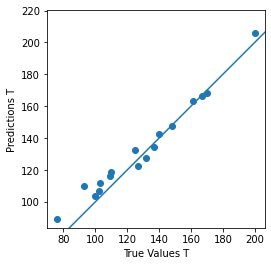

In [27]:
#Test the model
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values T')
plt.ylabel('Predictions T')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-220, 220], [-220, 220])

In [28]:
print(ds_t.count())

min    87
T      87
Ti     87
dtype: int64
